# Rabbit Island Data Imputation

### Libraries

In [75]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import folium as fm
from keplergl import KeplerGl
import seaborn as sns

from shapely.geometry import Polygon
from shapely.geometry import Point, LineString
from shapely.ops import nearest_points

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.semi_supervised import LabelPropagation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.semi_supervised import LabelSpreading


import lazypredict


# show all culomms in pandas dataframe
pd.set_option('display.max_columns', None)


## Import & Clean

### Import Plant Abbreviations

In [76]:
# import plant_abbreviations_CLEANED csv file
df_plant_abbreviations = pd.read_csv('plant_abbreviations_CLEANED.csv')

#make first row the column names
df_plant_abbreviations.columns = df_plant_abbreviations.iloc[0]
df_plant_abbreviations = df_plant_abbreviations[1:]

df_plant_abbreviations

,Name,Abbreviation,Type
1,moss,m,ground
2,mushroom,mu,ground
3,ground pine,gp,ground
4,lichen,l,ground
5,lycopodium,ly,ground
6,horseweed,hw,ground
7,goldenrod,gr,ground
8,fireweed,fw,ground
9,longtube twinflower,lttf,ground
10,grass,g,ground


### Import: research grid

In [77]:
# Import research grid
data = pd.read_csv('research_grid_2.csv')
df = data.copy()
df


,id,access,surveyed,ground_50,shrubs_50,trees_50,elevation,ndvi1,lat,lon
0,0,NaN,water,NaN,NaN,NaN,180.50,-0.05,47.08,-88.28
1,1,NaN,water,NaN,NaN,NaN,180.50,-0.05,47.08,-88.28
2,2,NaN,water,NaN,NaN,NaN,180.50,-0.05,47.08,-88.28
3,3,NaN,water,NaN,NaN,NaN,180.50,-0.05,47.08,-88.28
4,4,NaN,water,NaN,NaN,NaN,180.50,-0.05,47.08,-88.28
...,...,...,...,...,...,...,...,...,...,...
1844,1844,NaN,water,NaN,NaN,NaN,180.50,-0.08,47.07,-88.27
1845,1845,NaN,water,NaN,NaN,NaN,180.50,-0.07,47.07,-88.27
1846,1846,NaN,water,NaN,NaN,NaN,180.50,-0.06,47.07,-88.27
1847,1847,NaN,water,NaN,NaN,NaN,180.50,-0.05,47.07,-88.27


#### Clean Data Frame: df

In [78]:
# remove all rows with "water" in surveyed column and reset index <- because they are not needed
df = df[df['surveyed'] != 'water']
df = df.reset_index(drop=True)

# rename columns
df = df.rename(columns={'ground_50': 'ground' ,'shrubs_50' :'shrubs', 'trees_50':'trees', 'ndvi1':'ndvi'})

# convert surveyed column to n=0 and y=1
df['surveyed'] = df['surveyed'].map({'n': 0, 'y': 1})

df

,id,access,surveyed,ground,shrubs,trees,elevation,ndvi,lat,lon
0,117,s,1,NaN,r ma,wb pc re f,186.07,0.12,47.08,-88.27
1,118,s,1,m l,ma,wb mm f,184.16,0.35,47.08,-88.27
2,119,m,1,m l,cy ma,mm wb f,184.78,0.40,47.08,-88.27
3,120,s,1,m l,NaN,mm,185.96,0.38,47.08,-88.27
4,121,s,1,m,NaN,mm qa,185.60,0.22,47.08,-88.27
...,...,...,...,...,...,...,...,...,...,...
845,1753,m,1,m l,cy ma,wb f pc qa,183.43,0.16,47.07,-88.27
846,1754,m,1,m l,ma r cy,wb f rm,185.00,0.38,47.07,-88.27
847,1755,m,1,m l,ma cy,wb f mm,185.51,0.39,47.07,-88.27
848,1756,m,1,l m,ma,wb f mm pc,184.26,0.37,47.07,-88.27


In [79]:
# unique values for trees
df['trees'].nunique()

168

Replace divergent values: access

In [80]:
# show unique values in access column and their counts
df['access'].value_counts()

access
m      233
s      118
d      102
a        3
e        2
m l      2
Name: count, dtype: int64

In [81]:
# convert access column: "a" to "s", "e" to "s", "m l" to m
df['access'] = df['access'].replace({'a': 's', 'e': 's', 'm l': 'm'})

# show unique values in access column and their counts
df['access'].value_counts()

access
m    235
s    123
d    102
Name: count, dtype: int64

##### Strings to list: ground, shrubs, trees

In [82]:
# Split on whitespace
df['ground'] = df['ground'].str.split(r'\s+')
df['shrubs'] = df['shrubs'].str.split(r'\s+')
df['trees'] = df['trees'].str.split(r'\s+')

df.head(5)

,id,access,surveyed,ground,shrubs,trees,elevation,ndvi,lat,lon
0,117,s,1,NaN,"[r, ma]","[wb, pc, re, f]",186.07,0.12,47.08,-88.27
1,118,s,1,"[m, l]",[ma],"[wb, mm, f]",184.16,0.35,47.08,-88.27
2,119,m,1,"[m, l]","[cy, ma]","[mm, wb, f]",184.78,0.40,47.08,-88.27
3,120,s,1,"[m, l]",NaN,[mm],185.96,0.38,47.08,-88.27
4,121,s,1,[m],NaN,"[mm, qa]",185.60,0.22,47.08,-88.27


##### Replace NaNs: ground, shrubs, trees

In [83]:
def replace_NaN_if_surveyed(df, column):
    """
    Replace NaNs with empty lists in a column of a DataFrame if the 'surveyed' column is 1.
    """
    df[column] = df.apply(
        lambda row: row[column] if row['surveyed'] == 0 
                    else (row[column] if isinstance(row[column], list) else []),
        axis=1
    )
    return df

df = replace_NaN_if_surveyed(df, 'ground')
df = replace_NaN_if_surveyed(df, 'shrubs')
df = replace_NaN_if_surveyed(df, 'trees')

df.head(50)

,id,access,surveyed,ground,shrubs,trees,elevation,ndvi,lat,lon
0,117,s,1,[],"[r, ma]","[wb, pc, re, f]",186.07,0.12,47.08,-88.27
1,118,s,1,"[m, l]",[ma],"[wb, mm, f]",184.16,0.35,47.08,-88.27
2,119,m,1,"[m, l]","[cy, ma]","[mm, wb, f]",184.78,0.40,47.08,-88.27
3,120,s,1,"[m, l]",[],[mm],185.96,0.38,47.08,-88.27
4,121,s,1,[m],[],"[mm, qa]",185.60,0.22,47.08,-88.27
5,159,s,1,"[m, l]","[r, re]","[f, wb]",183.43,0.18,47.08,-88.27
6,160,m,1,"[m, l]",[],"[pc, f, wb]",186.07,0.38,47.08,-88.27
7,161,m,1,"[m, mu]",[cy],"[wb, f, mm]",184.16,0.40,47.08,-88.27
8,162,m,1,"[m, gp]",[cy],"[yb, mm, f]",184.78,0.44,47.08,-88.27
9,163,s,1,"[m, ly]","[ma, cy]","[mm, f]",185.96,0.49,47.08,-88.27


##### Delete Faulty Plant Abbreviations

In [84]:
# delete all values in ground, shrubs and trees columns that cannot be found in df_plant_abbreviations

def clean_plant_categories(df, df_plant_abbreviations):
    deleted = []

    for category in ['ground', 'shrubs', 'trees']:
        # Get allowed values for this category
        valid_set = set(df_plant_abbreviations[df_plant_abbreviations['Type'] == category]['Abbreviation'])

        # Clean each row in the column
        def filter_invalid(plants):
            if not isinstance(plants, list):
                return plants  # leave as-is if not a list
            invalid = [plant for plant in plants if plant not in valid_set]
            for plant in invalid:
                deleted.append((plant, category))
            return [plant for plant in plants if plant in valid_set]

        df[category] = df[category].apply(filter_invalid)

    # Create and print deleted values
    if deleted:
        deleted_df = pd.DataFrame(deleted, columns=['deleted_plant', 'type'])
        print("Deleted values:")
        print(deleted_df.drop_duplicates().to_string(index=False))
    else:
        print("No invalid values found.")

    return df

df = clean_plant_categories(df, df_plant_abbreviations)

Deleted values:
deleted_plant   type
         csjw ground
          bhs ground
          cnb ground
           ml ground
            n ground
         nbfi ground
           cy ground
            y ground
          bbw ground
            r shrubs
          asn shrubs
          bcw shrubs
           gr shrubs
           fw shrubs
           rb shrubs
           re  trees
           bh  trees
            m  trees
           ma  trees
          rmm  trees
           em  trees
         rmpc  trees


### Import Coastline Polygon

In [85]:
# add polygon from file
coastline = gpd.read_file('coastline.geojson')

## Feature Engineering

#### Distance from Coastline

In [86]:
# find closest point of df points to the coastline
gdf_points = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.lon, df.lat),
    crs='EPSG:4326'  # assuming WGS84
)

coastline_proj = coastline.to_crs(epsg=3857)
gdf_points_proj = gdf_points.to_crs(epsg=3857)

# If it's a MultiPolygon, merge and extract exterior
coastline_outline = coastline_proj.unary_union
if coastline_outline.geom_type == 'Polygon':
    coastline_outline = coastline_outline.exterior
elif coastline_outline.geom_type == 'MultiPolygon':
    coastline_outline = LineString([pt for poly in coastline_outline.geoms for pt in poly.exterior.coords])

def get_nearest_and_distance(point, line):
    nearest_pt = line.interpolate(line.project(point))
    distance = point.distance(nearest_pt)
    return nearest_pt, distance

# Apply to each point
nearest_points_list = []
distances = []

for point in gdf_points_proj.geometry:
    nearest_pt, dist = get_nearest_and_distance(point, coastline_outline)
    nearest_points_list.append(nearest_pt)
    distances.append(dist)

# Add to GeoDataFrame
gdf_points_proj['nearest_point'] = nearest_points_list
gdf_points_proj['distance_m'] = distances

gdf_points_proj


,id,access,surveyed,ground,shrubs,trees,elevation,ndvi,lat,lon,geometry,nearest_point,distance_m
0,117,s,1,[],[ma],"[wb, pc, f]",186.07,0.12,47.08,-88.27,POINT (-9826236.507 5954564.328),POINT (-9826237.97999543 5954566.198413748),2.38
1,118,s,1,"[m, l]",[ma],"[wb, mm, f]",184.16,0.35,47.08,-88.27,POINT (-9826206.507 5954564.328),POINT (-9826212.01586371 5954578.22020717),14.94
2,119,m,1,"[m, l]","[cy, ma]","[mm, wb, f]",184.78,0.40,47.08,-88.27,POINT (-9826176.506 5954564.328),POINT (-9826178.111432044 5954588.272167539),24.00
3,120,s,1,"[m, l]",[],[mm],185.96,0.38,47.08,-88.27,POINT (-9826146.517 5954564.328),POINT (-9826137.795953693 5954583.751466918),21.29
4,121,s,1,[m],[],"[mm, qa]",185.60,0.22,47.08,-88.27,POINT (-9826116.516 5954564.328),POINT (-9826111.486434117 5954573.953079554),10.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...
845,1753,m,1,"[m, l]","[cy, ma]","[wb, f, pc, qa]",183.43,0.16,47.07,-88.27,POINT (-9826176.506 5953424.338),POINT (-9826179.854411976 5953413.874494055),10.99
846,1754,m,1,"[m, l]","[ma, cy]","[wb, f, rm]",185.00,0.38,47.07,-88.27,POINT (-9826146.517 5953424.338),POINT (-9826147.57126585 5953405.205331033),19.16
847,1755,m,1,"[m, l]","[ma, cy]","[wb, f, mm]",185.51,0.39,47.07,-88.27,POINT (-9826116.516 5953424.338),POINT (-9826114.860772103 5953397.09902236),27.29
848,1756,m,1,"[l, m]",[ma],"[wb, f, mm, pc]",184.26,0.37,47.07,-88.27,POINT (-9826086.516 5953424.338),POINT (-9826079.584740473 5953403.419126002),22.04


Display Distance from Coastline in Map

In [87]:


# Create LineStrings between original point and nearest coastline point
lines = [
    LineString([orig, nearest])
    for orig, nearest in zip(gdf_points_proj.geometry, gdf_points_proj['nearest_point'])
]

# Create GeoDataFrame of lines
lines_gdf = gpd.GeoDataFrame(geometry=lines, crs=gdf_points_proj.crs)

# Optional: Add distance info for styling
lines_gdf['distance_m'] = gdf_points_proj['distance_m']

lines_wgs84 = lines_gdf.to_crs(epsg=4326)

map1 = KeplerGl(height=600)
map1.add_data(data=lines_wgs84, name='Distance Lines')

map1

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'Distance Lines': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, …

In [88]:
# add distance to the coastline to the dataframe
df['distance_to_coastline_in_m'] = gdf_points_proj['distance_m']
df

,id,access,surveyed,ground,shrubs,trees,elevation,ndvi,lat,lon,distance_to_coastline_in_m
0,117,s,1,[],[ma],"[wb, pc, f]",186.07,0.12,47.08,-88.27,2.38
1,118,s,1,"[m, l]",[ma],"[wb, mm, f]",184.16,0.35,47.08,-88.27,14.94
2,119,m,1,"[m, l]","[cy, ma]","[mm, wb, f]",184.78,0.40,47.08,-88.27,24.00
3,120,s,1,"[m, l]",[],[mm],185.96,0.38,47.08,-88.27,21.29
4,121,s,1,[m],[],"[mm, qa]",185.60,0.22,47.08,-88.27,10.86
...,...,...,...,...,...,...,...,...,...,...,...
845,1753,m,1,"[m, l]","[cy, ma]","[wb, f, pc, qa]",183.43,0.16,47.07,-88.27,10.99
846,1754,m,1,"[m, l]","[ma, cy]","[wb, f, rm]",185.00,0.38,47.07,-88.27,19.16
847,1755,m,1,"[m, l]","[ma, cy]","[wb, f, mm]",185.51,0.39,47.07,-88.27,27.29
848,1756,m,1,"[l, m]",[ma],"[wb, f, mm, pc]",184.26,0.37,47.07,-88.27,22.04


## Feature Encoding

### Label Encoding: Access

In [89]:
# label encode access as s=1, m=2, d=3 as integer
df['access'] = df['access'].map({'s': 1, 'm': 2, 'd': 3})

df

,id,access,surveyed,ground,shrubs,trees,elevation,ndvi,lat,lon,distance_to_coastline_in_m
0,117,1.00,1,[],[ma],"[wb, pc, f]",186.07,0.12,47.08,-88.27,2.38
1,118,1.00,1,"[m, l]",[ma],"[wb, mm, f]",184.16,0.35,47.08,-88.27,14.94
2,119,2.00,1,"[m, l]","[cy, ma]","[mm, wb, f]",184.78,0.40,47.08,-88.27,24.00
3,120,1.00,1,"[m, l]",[],[mm],185.96,0.38,47.08,-88.27,21.29
4,121,1.00,1,[m],[],"[mm, qa]",185.60,0.22,47.08,-88.27,10.86
...,...,...,...,...,...,...,...,...,...,...,...
845,1753,2.00,1,"[m, l]","[cy, ma]","[wb, f, pc, qa]",183.43,0.16,47.07,-88.27,10.99
846,1754,2.00,1,"[m, l]","[ma, cy]","[wb, f, rm]",185.00,0.38,47.07,-88.27,19.16
847,1755,2.00,1,"[m, l]","[ma, cy]","[wb, f, mm]",185.51,0.39,47.07,-88.27,27.29
848,1756,2.00,1,"[l, m]",[ma],"[wb, f, mm, pc]",184.26,0.37,47.07,-88.27,22.04


In [90]:
# convert all boolean columns to int if not null
for col in df.columns:
    if df[col].dtype == bool:
        df[col] = df[col].astype(int)

df

,id,access,surveyed,ground,shrubs,trees,elevation,ndvi,lat,lon,distance_to_coastline_in_m
0,117,1.00,1,[],[ma],"[wb, pc, f]",186.07,0.12,47.08,-88.27,2.38
1,118,1.00,1,"[m, l]",[ma],"[wb, mm, f]",184.16,0.35,47.08,-88.27,14.94
2,119,2.00,1,"[m, l]","[cy, ma]","[mm, wb, f]",184.78,0.40,47.08,-88.27,24.00
3,120,1.00,1,"[m, l]",[],[mm],185.96,0.38,47.08,-88.27,21.29
4,121,1.00,1,[m],[],"[mm, qa]",185.60,0.22,47.08,-88.27,10.86
...,...,...,...,...,...,...,...,...,...,...,...
845,1753,2.00,1,"[m, l]","[cy, ma]","[wb, f, pc, qa]",183.43,0.16,47.07,-88.27,10.99
846,1754,2.00,1,"[m, l]","[ma, cy]","[wb, f, rm]",185.00,0.38,47.07,-88.27,19.16
847,1755,2.00,1,"[m, l]","[ma, cy]","[wb, f, mm]",185.51,0.39,47.07,-88.27,27.29
848,1756,2.00,1,"[l, m]",[ma],"[wb, f, mm, pc]",184.26,0.37,47.07,-88.27,22.04


### One Hot Encoding: ground, shrubs, trees

In [91]:
import numpy as np

def encode_abbreviations_with_survey_check(df, df_plant_abbreviations, type_col='Type', abbrev_col='Abbreviation'):
    for _, row in df_plant_abbreviations.iterrows():
        category = row[type_col]     # 'ground', 'shrubs', or 'trees'
        abbrev = row[abbrev_col]     # plant abbreviation

        # Define new column for this abbreviation
        new_col = f'{abbrev}'

        # Define encoding function with survey check
        def encode(row):
            if row['surveyed'] == 0:
                return np.nan
            if not isinstance(row[category], list):
                return 0
            return int(abbrev in row[category])

        # Apply row-wise
        df[new_col] = df.apply(encode, axis=1)

    return df


df = encode_abbreviations_with_survey_check(df, df_plant_abbreviations)



df.head(60)

,id,access,surveyed,ground,shrubs,trees,elevation,ndvi,lat,lon,distance_to_coastline_in_m,m,mu,gp,l,ly,hw,gr,fw,lttf,g,mehw,cm,bm,cd,bw,jh,sv,bepw,csh,oed,bbbf,d,nfm,wf,wl,wsb,rod,reb,bh,bhs,cwb,rc,csb,cy,ma,re,cnb,qa,f,mm,p,pc,rm,wb,yb,avc,ws,bta
0,117,1.00,1,[],[ma],"[wb, pc, f]",186.07,0.12,47.08,-88.27,2.38,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00
1,118,1.00,1,"[m, l]",[ma],"[wb, mm, f]",184.16,0.35,47.08,-88.27,14.94,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
2,119,2.00,1,"[m, l]","[cy, ma]","[mm, wb, f]",184.78,0.40,47.08,-88.27,24.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
3,120,1.00,1,"[m, l]",[],[mm],185.96,0.38,47.08,-88.27,21.29,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,121,1.00,1,[m],[],"[mm, qa]",185.60,0.22,47.08,-88.27,10.86,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,159,1.00,1,"[m, l]",[re],"[f, wb]",183.43,0.18,47.08,-88.27,4.43,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
6,160,2.00,1,"[m, l]",[],"[pc, f, wb]",186.07,0.38,47.08,-88.27,25.95,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00
7,161,2.00,1,"[m, mu]",[cy],"[wb, f, mm]",184.16,0.40,47.08,-88.27,42.83,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
8,162,2.00,1,"[m, gp]",[cy],"[yb, mm, f]",184.78,0.44,47.08,-88.27,53.08,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
9,163,1.00,1,"[m, ly]","[ma, cy]","[mm, f]",185.96,0.49,47.08,-88.27,48.66,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### Separate "Surveyed" and "Not Surveyed"

In [92]:
# separate df into two dataframes: one with surveyed and one with not surveyed
df_surveyed = df[df['surveyed'] == 1]
df_not_surveyed = df[df['surveyed'] == 0]

df

,id,access,surveyed,ground,shrubs,trees,elevation,ndvi,lat,lon,distance_to_coastline_in_m,m,mu,gp,l,ly,hw,gr,fw,lttf,g,mehw,cm,bm,cd,bw,jh,sv,bepw,csh,oed,bbbf,d,nfm,wf,wl,wsb,rod,reb,bh,bhs,cwb,rc,csb,cy,ma,re,cnb,qa,f,mm,p,pc,rm,wb,yb,avc,ws,bta
0,117,1.00,1,[],[ma],"[wb, pc, f]",186.07,0.12,47.08,-88.27,2.38,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00
1,118,1.00,1,"[m, l]",[ma],"[wb, mm, f]",184.16,0.35,47.08,-88.27,14.94,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
2,119,2.00,1,"[m, l]","[cy, ma]","[mm, wb, f]",184.78,0.40,47.08,-88.27,24.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
3,120,1.00,1,"[m, l]",[],[mm],185.96,0.38,47.08,-88.27,21.29,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,121,1.00,1,[m],[],"[mm, qa]",185.60,0.22,47.08,-88.27,10.86,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
845,1753,2.00,1,"[m, l]","[cy, ma]","[wb, f, pc, qa]",183.43,0.16,47.07,-88.27,10.99,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00
846,1754,2.00,1,"[m, l]","[ma, cy]","[wb, f, rm]",185.00,0.38,47.07,-88.27,19.16,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00
847,1755,2.00,1,"[m, l]","[ma, cy]","[wb, f, mm]",185.51,0.39,47.07,-88.27,27.29,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
848,1756,2.00,1,"[l, m]",[ma],"[wb, f, mm, pc]",184.26,0.37,47.07,-88.27,22.04,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00


### Drop Columns

In [93]:
# drop all columns that are not needed for the model: surveyed, ground, shrubs, trees, lon, lat
df_surveyed = df_surveyed.drop(columns=['id', 'surveyed', 'ground', 'shrubs', 'trees'])
df_surveyed

,access,elevation,ndvi,lat,lon,distance_to_coastline_in_m,m,mu,gp,l,ly,hw,gr,fw,lttf,g,mehw,cm,bm,cd,bw,jh,sv,bepw,csh,oed,bbbf,d,nfm,wf,wl,wsb,rod,reb,bh,bhs,cwb,rc,csb,cy,ma,re,cnb,qa,f,mm,p,pc,rm,wb,yb,avc,ws,bta
0,1.00,186.07,0.12,47.08,-88.27,2.38,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00
1,1.00,184.16,0.35,47.08,-88.27,14.94,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
2,2.00,184.78,0.40,47.08,-88.27,24.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
3,1.00,185.96,0.38,47.08,-88.27,21.29,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,1.00,185.60,0.22,47.08,-88.27,10.86,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
845,2.00,183.43,0.16,47.07,-88.27,10.99,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00
846,2.00,185.00,0.38,47.07,-88.27,19.16,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00
847,2.00,185.51,0.39,47.07,-88.27,27.29,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
848,2.00,184.26,0.37,47.07,-88.27,22.04,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00


## Modeling Test for One Target

In [94]:
# drop all plant columns except gp
target = "gp"
features = ['elevation', 'ndvi', 'distance_to_coastline_in_m','lon', 'lat']
df_surveyed = df_surveyed[features + [target]]

df_surveyed

,elevation,ndvi,distance_to_coastline_in_m,lon,lat,gp
0,186.07,0.12,2.38,-88.27,47.08,0.00
1,184.16,0.35,14.94,-88.27,47.08,0.00
2,184.78,0.40,24.00,-88.27,47.08,0.00
3,185.96,0.38,21.29,-88.27,47.08,0.00
4,185.60,0.22,10.86,-88.27,47.08,0.00
...,...,...,...,...,...,...
845,183.43,0.16,10.99,-88.27,47.07,0.00
846,185.00,0.38,19.16,-88.27,47.07,0.00
847,185.51,0.39,27.29,-88.27,47.07,0.00
848,184.26,0.37,22.04,-88.27,47.07,0.00


### Move Target to End

In [95]:
# move target column to the end
df_surveyed = df_surveyed[[col for col in df_surveyed.columns if col != 'gp'] + ['gp']]

df_surveyed

,elevation,ndvi,distance_to_coastline_in_m,lon,lat,gp
0,186.07,0.12,2.38,-88.27,47.08,0.00
1,184.16,0.35,14.94,-88.27,47.08,0.00
2,184.78,0.40,24.00,-88.27,47.08,0.00
3,185.96,0.38,21.29,-88.27,47.08,0.00
4,185.60,0.22,10.86,-88.27,47.08,0.00
...,...,...,...,...,...,...
845,183.43,0.16,10.99,-88.27,47.07,0.00
846,185.00,0.38,19.16,-88.27,47.07,0.00
847,185.51,0.39,27.29,-88.27,47.07,0.00
848,184.26,0.37,22.04,-88.27,47.07,0.00


In [96]:
num = df_surveyed.select_dtypes(include="number")

In [97]:
num.corr()["gp"].sort_values(ascending=True)

lon                          -0.05
lat                          -0.02
ndvi                          0.29
distance_to_coastline_in_m    0.41
elevation                     0.43
gp                            1.00
Name: gp, dtype: float64

### Check Multicolinearity

In [98]:
num_corr = num.corr().round(2)

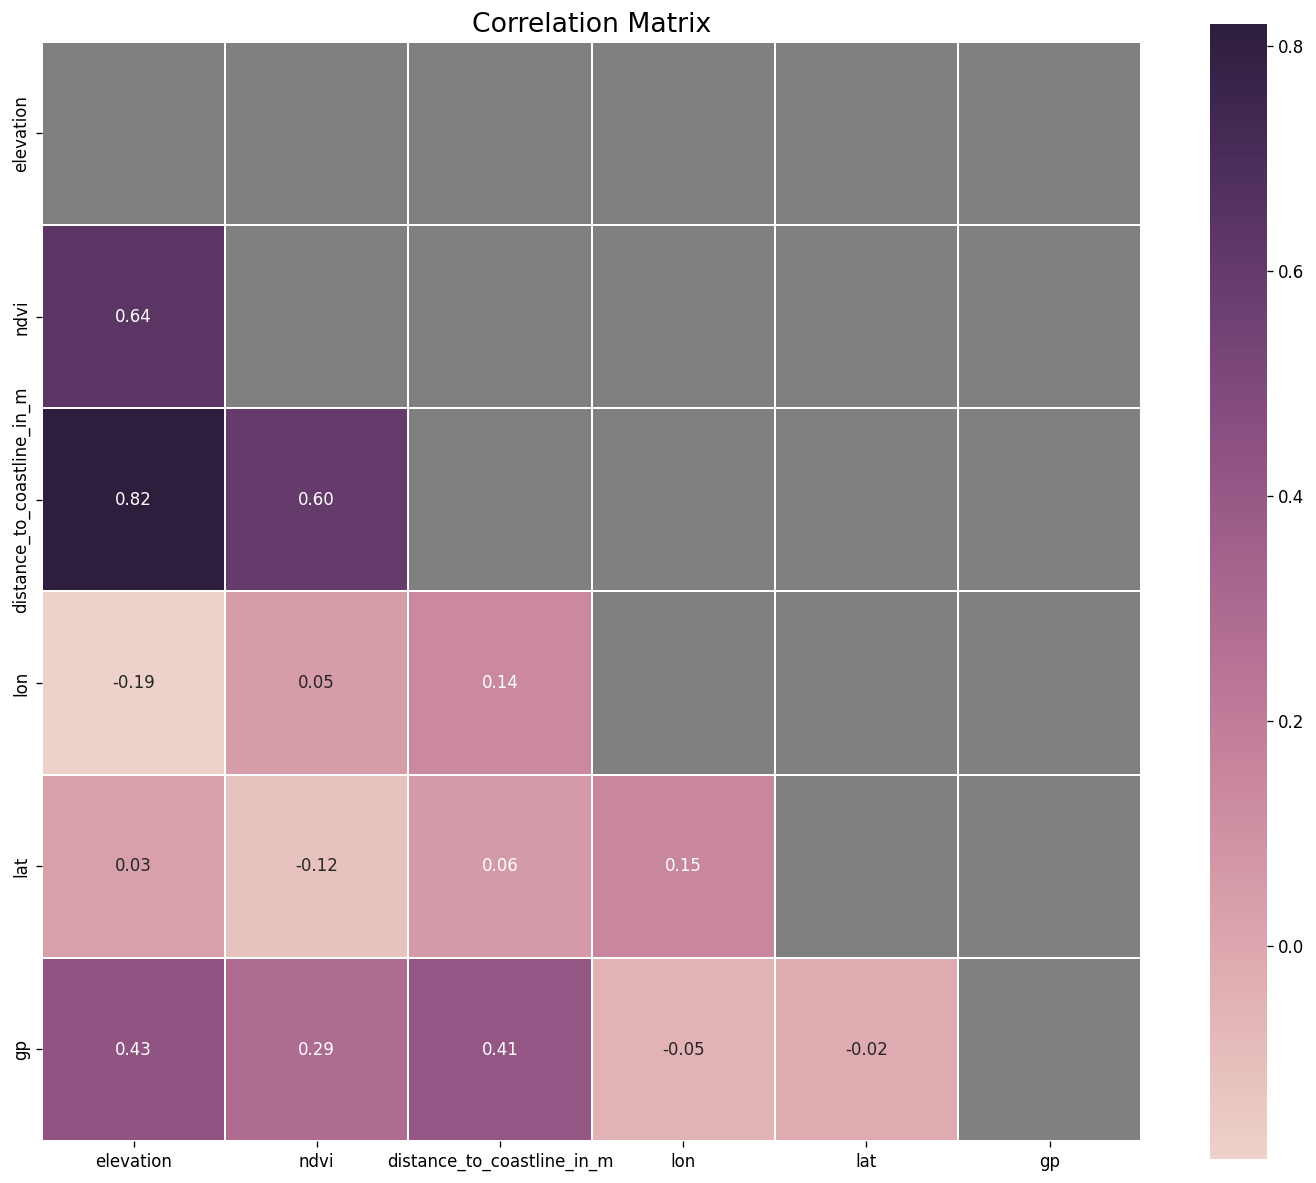

In [99]:
mask = np.zeros_like(num_corr)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(12, 10), dpi=120)
cubehelix_cmap = sns.cubehelix_palette(as_cmap=True)

ax = sns.heatmap(
    num_corr,
    mask=mask,
    cmap=cubehelix_cmap,
    annot=True,
    fmt=".2f",
    annot_kws={"size": 10},
    square=True,
    linewidths=1,
    linecolor='white',
    cbar=True
)

ax.set_facecolor('gray')
ax.set_title("Correlation Matrix", fontsize=16)
plt.tight_layout()
plt.show()


### Data Pre-Processing

In [100]:
X = df_surveyed.drop("gp", axis=1)
y = df_surveyed["gp"]

### Modeling

#### Train-Test Split

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [102]:
print(f'100% of our data: {len(df)}.')
print(f'70% for training data: {len(X_train)}.')
print(f'30% for test data: {len(X_test)}.')

100% of our data: 850.
70% for training data: 322.
30% for test data: 138.


#### Logistic Regression

In [103]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [104]:
predictions = model.predict(X_test)
print(f'30% for test prediction data: {len(predictions)}.')

30% for test prediction data: 138.


In [105]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.88      0.99      0.93       122
         1.0       0.00      0.00      0.00        16

    accuracy                           0.88       138
   macro avg       0.44      0.50      0.47       138
weighted avg       0.78      0.88      0.83       138



#### Random Forest Classifier

In [106]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [107]:
predictions = model.predict(X_test)

In [108]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.96       122
         1.0       0.89      0.50      0.64        16

    accuracy                           0.93       138
   macro avg       0.91      0.75      0.80       138
weighted avg       0.93      0.93      0.93       138



In [109]:
print("Test data accuracy: ",model.score(X_test,y_test))
print("Train data accuracy: ", model.score(X_train, y_train))

Test data accuracy:  0.9347826086956522
Train data accuracy:  1.0


<Figure size 800x600 with 0 Axes>

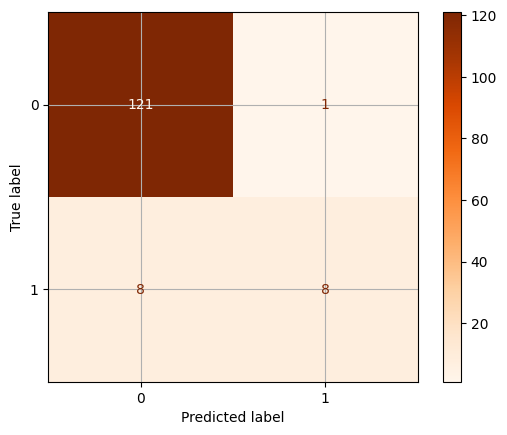

In [110]:
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.figure(figsize=(8, 6))
disp.plot(cmap='Oranges')  
plt.grid(True)
plt.show()

In [111]:
feature_names = list(X_train.columns)
importances = model.feature_importances_
indices = np.argsort(importances)[::-1] # sorts indices of importances in descending order

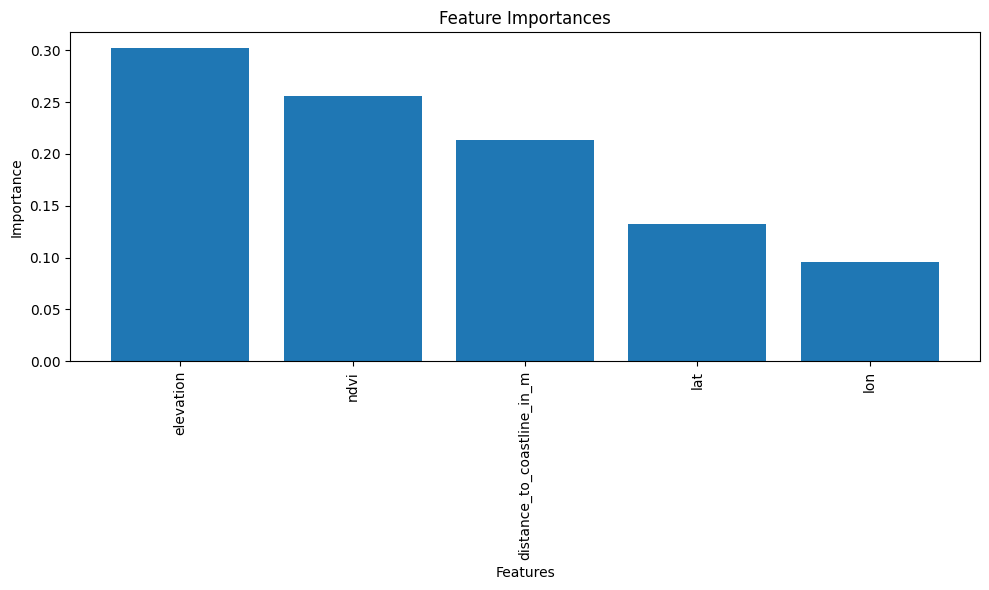

In [112]:
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

#### Check Balance

In [113]:
df_surveyed['gp'].value_counts(normalize=False)


gp
0.00    409
1.00     51
Name: count, dtype: int64

#### Oversampling

In [114]:
from sklearn.utils import resample
train = pd.concat([X_train, y_train], axis=1)
no_gp = train[train['gp']==0]
gp = train[train['gp']==1]

In [115]:
display(no_gp.shape)
display(gp.shape)

(287, 6)

(35, 6)

In [116]:
oversampled_gp = resample(gp,
                                replace=True,  # Sample with replacement
                                n_samples=len(no_gp),  # Match number in majority class
                                random_state=42)  # Reproducible results

In [117]:
display(no_gp.shape)
display(oversampled_gp.shape)

(287, 6)

(287, 6)

In [118]:
train_oversampled = pd.concat([no_gp,oversampled_gp])
train_oversampled.sample(10)

,elevation,ndvi,distance_to_coastline_in_m,lon,lat,gp
752,188.50,0.44,82.36,-88.27,47.07,0.00
416,206.46,0.51,237.07,-88.27,47.07,1.00
8,184.78,0.44,53.08,-88.27,47.08,1.00
318,188.78,0.47,46.21,-88.27,47.07,0.00
111,188.31,0.36,22.36,-88.27,47.07,0.00
323,199.76,0.44,92.57,-88.27,47.07,0.00
504,191.92,0.36,74.10,-88.28,47.07,0.00
621,201.41,0.43,152.98,-88.27,47.07,1.00
8,184.78,0.44,53.08,-88.27,47.08,1.00
169,195.52,0.36,153.20,-88.27,47.07,0.00


In [119]:
X_train = train_oversampled.drop('gp',axis = 1).copy()
y_train = train_oversampled['gp'].copy()

In [120]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [121]:
predictions = model.predict(X_test)

In [122]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.97      0.96      0.97       122
         1.0       0.72      0.81      0.76        16

    accuracy                           0.94       138
   macro avg       0.85      0.89      0.87       138
weighted avg       0.95      0.94      0.94       138



In [123]:
print("Test data accuracy: ",model.score(X_test,y_test))
print("Train data accuracy: ", model.score(X_train, y_train))

Test data accuracy:  0.9420289855072463
Train data accuracy:  1.0


<Figure size 800x600 with 0 Axes>

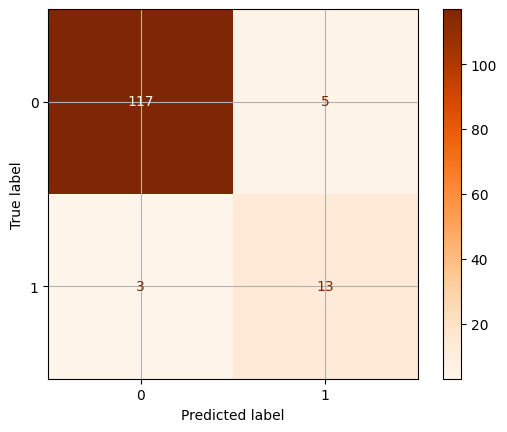

In [124]:
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.figure(figsize=(8, 6))
disp.plot(cmap='Oranges')  
plt.grid(True)
plt.show()

#### GridSearch

In [125]:
from sklearn.model_selection import GridSearchCV


In [126]:
# parameters = {
#     'bootstrap': [True], 
#     'max_depth': [20, 40, 60, None],
#     'max_features': ['sqrt', 'log2', None],
#     'min_samples_leaf': [1, 2],
#     'min_samples_split': [2, 5],
#     'n_estimators': [200, 400, 600]
# }

# model = RandomForestClassifier()

# model = GridSearchCV(model, parameters)
# model.fit(X_train, y_train)

# predictions = model.predict(X_test)

In [127]:
# model = RandomForestClassifier()

In [128]:
# model = GridSearchCV(model, parameters)
# model.fit(X_train, y_train)

In [129]:
# predictions = model.predict(X_test)

In [130]:
# print(classification_report(y_test, predictions))

#### LazyPredict

In [131]:
from lazypredict.Supervised import LazyClassifier

classifier = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)  # Lazzzzyyy

models, predictions = classifier.fit(X_train, X_test, y_train, y_test)

print(models.head(10))  # BEST 10 MODELS HEHE


100%|██████████| 32/32 [00:00<00:00, 33.32it/s]

[LightGBM] [Info] Number of positive: 287, number of negative: 287
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 458
[LightGBM] [Info] Number of data points in the train set: 574, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

#### LabelPropagation

In [132]:
# Hide 70% of the training labels (set them to -1)
rng = np.random.default_rng(42)
mask = rng.choice([True, False], size=y_train.shape, p=[0.7, 0.3])
y_train_semi = np.copy(y_train)
y_train_semi[mask] = -1

In [133]:

model = LabelPropagation()
model.fit(X_train, y_train_semi)

# Predict on the test set
predictions = model.predict(X_test)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.92      0.89      0.90       122
         1.0       0.30      0.38      0.33        16

    accuracy                           0.83       138
   macro avg       0.61      0.63      0.62       138
weighted avg       0.84      0.83      0.83       138



#### Label Spreading

In [134]:

# Create a copy of y_train where you hide some labels
y_train_semi = np.copy(y_train)

# Mask: hide 80% of the labels
rng = np.random.default_rng(42)
mask = rng.choice([True, False], size=y_train.shape, p=[0.8, 0.2])
y_train_semi[mask] = -1  # Unlabeled

model = LabelSpreading()
model.fit(X_train, y_train)


LabelSpreading()

In [135]:
predictions = model.predict(X_test)


In [136]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.91      0.83      0.87       122
         1.0       0.22      0.38      0.28        16

    accuracy                           0.78       138
   macro avg       0.57      0.60      0.57       138
weighted avg       0.83      0.78      0.80       138



#### KNeighborsClassifier

In [137]:
model = KNeighborsClassifier(n_neighbors=1)  # You can tweak this number
model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [138]:
predictions = model.predict(X_test)

In [139]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         0
         0.0       0.91      0.17      0.29       122
         1.0       0.00      0.00      0.00        16

    accuracy                           0.15       138
   macro avg       0.30      0.06      0.10       138
weighted avg       0.81      0.15      0.26       138



## Automate for all Targets

In [140]:
# Separate df into two dataframes: one with surveyed and one with not surveyed
df_surveyed = df[df['surveyed'] == 1]
df_not_surveyed = df[df['surveyed'] == 0]

# drop all plant columns except gp
targets = ['m','mu','gp','l','ly','hw','gr','fw','lttf','g','mehw','cm','bm','cd','bw','jh','sv','bepw','csh','oed','bbbf','d','nfm','wf','wl','wsb','rod','reb','bh','bhs','cwb','rc','csb','cy','ma','re','cnb','qa','f','mm','p','pc','rm','wb','yb','avc','ws','bta'] 
features = ['elevation', 'ndvi', 'distance_to_coastline_in_m','lon', 'lat']

#### Check Frequency of Targets

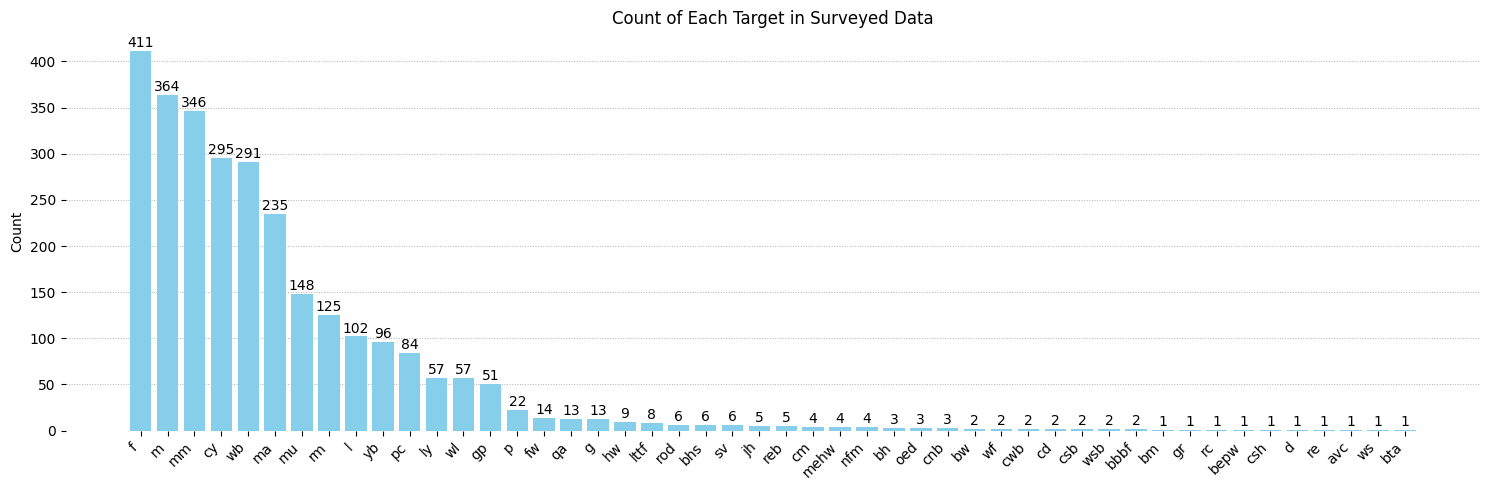

In [141]:

# Get the counts
target_counts = df_surveyed[targets].sum().astype(int).sort_values(ascending=False)

# Plot the bar chart
fig, ax = plt.subplots(figsize=(15, 5))
bars = ax.bar(target_counts.index, target_counts.values, color='skyblue')

# Add count labels on top of each bar
for i, count in enumerate(target_counts):
    ax.text(i, count + 1, str(count), ha='center', va='bottom', fontsize=10)

# Remove the frame (spines)
for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_visible(False)

# Add dotted grid lines
ax.yaxis.grid(True, linestyle=':', linewidth=0.7)
ax.set_axisbelow(True)  # Draw grid behind bars

# Optional: Improve layout
ax.set_ylabel('Count')
ax.set_title('Count of Each Target in Surveyed Data')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()


#### Exclude Targets with Low Frequency

In [142]:
# define threshold for the number of plants to be considered
threshold = 10

# exclude all plants that are below the threshold from targets
targets = target_counts[target_counts > threshold].index

targets

Index(['f', 'm', 'mm', 'cy', 'wb', 'ma', 'mu', 'rm', 'l', 'yb', 'pc', 'ly',
       'wl', 'gp', 'p', 'fw', 'qa', 'g'],
      dtype='object')

#### Model Evaluation

In [143]:


for target in targets:
    df_surveyed_target = df_surveyed[features + [target]]
    df_surveyed_target = df_surveyed_target[[col for col in df_surveyed_target.columns if col != target] + [target]]

    X = df_surveyed_target.drop(target, axis=1).copy()
    y = df_surveyed_target[target].copy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    train = pd.concat([X_train, y_train], axis=1)
    no_plant = train[train[target] == 0]
    plant = train[train[target] == 1]

    if plant.empty or no_plant.empty:
        print(f" Skipping {target}: one of the classes is empty.")
        continue

    oversampled_plant = resample(plant,
                                 replace=True,
                                 n_samples=len(no_plant),
                                 random_state=42)

    train_oversampled = pd.concat([no_plant, oversampled_plant])
    X_train = train_oversampled.drop(target, axis=1).copy()
    y_train = train_oversampled[target].copy()

    model = RandomForestClassifier(max_depth=20, n_estimators=400) # <- parameters from grid search
    model.fit(X_train, y_train)

    predictions = model.predict(X_test)

    # Check test set class balance BEFORE evaluation
    if len(y_test.unique()) < 2:
        print(f" Skipping {target}: test set has only one class.")
        continue

    print(f" Results for {target}:")
    print(classification_report(y_test, predictions))

    

 Results for f:
              precision    recall  f1-score   support

         0.0       0.18      0.67      0.28        15
         1.0       0.94      0.62      0.75       123

    accuracy                           0.62       138
   macro avg       0.56      0.64      0.51       138
weighted avg       0.86      0.62      0.69       138

 Results for m:
              precision    recall  f1-score   support

         0.0       0.53      0.77      0.63        31
         1.0       0.92      0.80      0.86       107

    accuracy                           0.80       138
   macro avg       0.73      0.79      0.75       138
weighted avg       0.84      0.80      0.81       138

 Results for mm:
              precision    recall  f1-score   support

         0.0       0.44      0.82      0.57        33
         1.0       0.92      0.68      0.78       105

    accuracy                           0.71       138
   macro avg       0.68      0.75      0.68       138
weighted avg       0.81  

#### Apply to NOT surveyed points

In [144]:
predicted_targets = pd.DataFrame(index=df_not_surveyed.index)

for target in targets:
    df_surveyed_target = df_surveyed[features + [target]]
    
    X = df_surveyed_target.drop(target, axis=1).copy()
    y = df_surveyed_target[target].copy()

    # Train/test split (you’ve already done this in earlier steps)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Handle imbalance
    train = pd.concat([X_train, y_train], axis=1)
    no_plant = train[train[target] == 0]
    plant = train[train[target] == 1]

    if plant.empty or no_plant.empty:
        print(f"Skipping {target}: one of the classes is empty.")
        continue

    oversampled_plant = resample(plant,
                                 replace=True,
                                 n_samples=len(no_plant),
                                 random_state=42)

    train_oversampled = pd.concat([no_plant, oversampled_plant])
    X_train = train_oversampled.drop(target, axis=1).copy()
    y_train = train_oversampled[target].copy()

    # Train model
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    # Predict on df_not_surveyed
    X_unseen = df_not_surveyed[features].copy()
    predicted_targets[target] = model.predict(X_unseen)


#### Save Results

In [145]:
df_not_surveyed_filled = df_not_surveyed.copy()
df_not_surveyed_filled[targets] = predicted_targets
df_not_surveyed_filled

,id,access,surveyed,ground,shrubs,trees,elevation,ndvi,lat,lon,distance_to_coastline_in_m,m,mu,gp,l,ly,hw,gr,fw,lttf,g,mehw,cm,bm,cd,bw,jh,sv,bepw,csh,oed,bbbf,d,nfm,wf,wl,wsb,rod,reb,bh,bhs,cwb,rc,csb,cy,ma,re,cnb,qa,f,mm,p,pc,rm,wb,yb,avc,ws,bta
22,245,NaN,0,NaN,NaN,NaN,188.85,0.47,47.08,-88.27,41.35,1.00,0.00,0.00,0.00,0.00,NaN,NaN,0.00,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,NaN,NaN,NaN
23,246,NaN,0,NaN,NaN,NaN,188.48,0.47,47.08,-88.27,66.69,1.00,0.00,0.00,0.00,0.00,NaN,NaN,0.00,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,0.00,NaN,NaN,0.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00,NaN,NaN,NaN
24,247,NaN,0,NaN,NaN,NaN,189.62,0.45,47.08,-88.27,89.14,1.00,1.00,0.00,0.00,0.00,NaN,NaN,0.00,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,0.00,NaN,NaN,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,NaN,NaN,NaN
25,248,NaN,0,NaN,NaN,NaN,189.93,0.47,47.08,-88.27,109.67,0.00,0.00,0.00,0.00,0.00,NaN,NaN,0.00,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,0.00,NaN,NaN,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,NaN,NaN,NaN
26,249,NaN,0,NaN,NaN,NaN,188.87,0.42,47.08,-88.27,95.86,1.00,1.00,0.00,0.00,0.00,NaN,NaN,0.00,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,0.00,NaN,NaN,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
837,1671,NaN,0,NaN,NaN,NaN,184.74,0.48,47.07,-88.27,31.67,1.00,0.00,0.00,1.00,0.00,NaN,NaN,0.00,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,0.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00,NaN,NaN,NaN
840,1710,NaN,0,NaN,NaN,NaN,188.09,0.40,47.07,-88.27,33.68,1.00,0.00,0.00,0.00,0.00,NaN,NaN,0.00,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,1.00,NaN,NaN,0.00,1.00,1.00,0.00,0.00,1.00,1.00,0.00,NaN,NaN,NaN
841,1711,NaN,0,NaN,NaN,NaN,188.41,0.46,47.07,-88.27,49.13,1.00,1.00,0.00,0.00,0.00,NaN,NaN,0.00,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,1.00,NaN,NaN,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,NaN,NaN,NaN
842,1712,NaN,0,NaN,NaN,NaN,187.47,0.46,47.07,-88.27,57.22,1.00,1.00,0.00,0.00,0.00,NaN,NaN,0.00,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,1.00,NaN,NaN,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN


In [146]:
df_complete = pd.concat([df_surveyed, df_not_surveyed_filled])
df_complete

,id,access,surveyed,ground,shrubs,trees,elevation,ndvi,lat,lon,distance_to_coastline_in_m,m,mu,gp,l,ly,hw,gr,fw,lttf,g,mehw,cm,bm,cd,bw,jh,sv,bepw,csh,oed,bbbf,d,nfm,wf,wl,wsb,rod,reb,bh,bhs,cwb,rc,csb,cy,ma,re,cnb,qa,f,mm,p,pc,rm,wb,yb,avc,ws,bta
0,117,1.00,1,[],[ma],"[wb, pc, f]",186.07,0.12,47.08,-88.27,2.38,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00
1,118,1.00,1,"[m, l]",[ma],"[wb, mm, f]",184.16,0.35,47.08,-88.27,14.94,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
2,119,2.00,1,"[m, l]","[cy, ma]","[mm, wb, f]",184.78,0.40,47.08,-88.27,24.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
3,120,1.00,1,"[m, l]",[],[mm],185.96,0.38,47.08,-88.27,21.29,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,121,1.00,1,[m],[],"[mm, qa]",185.60,0.22,47.08,-88.27,10.86,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
837,1671,NaN,0,NaN,NaN,NaN,184.74,0.48,47.07,-88.27,31.67,1.00,0.00,0.00,1.00,0.00,NaN,NaN,0.00,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,0.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00,NaN,NaN,NaN
840,1710,NaN,0,NaN,NaN,NaN,188.09,0.40,47.07,-88.27,33.68,1.00,0.00,0.00,0.00,0.00,NaN,NaN,0.00,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,1.00,NaN,NaN,0.00,1.00,1.00,0.00,0.00,1.00,1.00,0.00,NaN,NaN,NaN
841,1711,NaN,0,NaN,NaN,NaN,188.41,0.46,47.07,-88.27,49.13,1.00,1.00,0.00,0.00,0.00,NaN,NaN,0.00,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,1.00,NaN,NaN,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,NaN,NaN,NaN
842,1712,NaN,0,NaN,NaN,NaN,187.47,0.46,47.07,-88.27,57.22,1.00,1.00,0.00,0.00,0.00,NaN,NaN,0.00,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,1.00,NaN,NaN,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN


In [147]:

#save the dataframe to a csv file
df_complete.to_csv('df_complete.csv', index=False)